In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
DATA_PATH = "C:\dane" #Sciezka do rozpakowanego zbioru danych

normal_path = os.path.join(DATA_PATH, "hem")
all_path = os.path.join(DATA_PATH, "all")

normal_images = [[x] for x in os.listdir(normal_path)]
all_images = [[x] for x in os.listdir(all_path)]

# Słownik zawierający mapowanie numer klasy -> nazwa klasy
CLASS_TO_FOLDER = {
    1: "all",
    0: "hem"
}

CLASS_WEIGHTS = {
    0: 1.57,
    1: 0.73
}

print(f"zbiór Normal:  {len(normal_images)}")
print(f"zbiór ALL: {len(all_images)}")

zbiór Normal:  3389
zbiór ALL: 7272


In [ ]:
from collections import namedtuple
from sklearn.model_selection import train_test_split

Case = namedtuple("Case", "image_name label")
LoadedCase = namedtuple("LoadedCase", "image label")

# Normal
normal_img_train, normal_img_test, _, _ = train_test_split(normal_images, [0] * len(normal_images),  test_size=0.3, random_state=42)
normal_img_test, normal_img_val, _, _ = train_test_split([x[0] for x in normal_img_test], [0] * len(normal_img_test),  test_size=0.33, random_state=32)

# ALL
all_img_train, all_img_test, _, _ = train_test_split(all_images, [1] * len(all_images),  test_size=0.3, random_state=42)
all_img_test, all_img_val, _, _ = train_test_split([x[0] for x in all_img_test], [1] * len(all_img_test),  test_size=0.33, random_state=32)

# Scalenie zbiorów
training_set = [Case(image_name=x[0], label=1) for x in all_img_train] + [Case(image_name=x[0], label=0) for x in normal_img_train]
test_set = [Case(image_name=x, label=0) for x in normal_img_test]  + [Case(image_name=x, label=1) for x in all_img_test]
validation_set = [Case(image_name=x, label=0) for x in normal_img_val] + [Case(image_name=x, label=1) for x in all_img_val]


print(f"zbiór treningowy:  {len(training_set)}")
print(f"zbiór testowy: {len(test_set)}")
print(f"zbiór walidacyjny: {len(validation_set)}")

zbiór treningowy:  7462
zbiór testowy: 2142
zbiór walidacyjny: 1057


In [ ]:
# Stworzenie transformacji
from PIL import Image
from PIL import ImageOps
from typing import List
import tensorflow as tf


def load_image(case: Case):
    image_path = os.path.join(DATA_PATH, CLASS_TO_FOLDER[case.label], case.image_name)
    image = Image.open(image_path, 'r')
    return image

def transform_image(img):
    img = img.resize((144,144))
    #img = ImageOps.grayscale(img)

    # konwersja na tensor
    img = np.asarray(img)
    img = tf.convert_to_tensor(img)
    img = tf.cast(img, dtype=tf.float32)

    # Normalizacja do wartości 0-1
    img = tf.divide(tf.subtract(img, tf.reduce_min(img)), tf.subtract(tf.reduce_max(img), tf.reduce_min(img)))

    return img

def prepare_images(cases: List[Case]):
    return [LoadedCase(image = transform_image(load_image(case)), label=case.label) for case in cases]

In [ ]:
#del normal_images
del normal_img_test
del normal_img_train
del normal_img_val
#del viralp_images
del all_img_test
del all_img_train
del all_img_val

del normal_images
del all_images
del normal_path
del all_path

In [ ]:
def prepare_dataset(dataset):
  X = np.zeros((len(dataset),144, 144,3))
  Y = np.zeros(len(dataset))
  for i in range(len(dataset)):
    X[i] = np.array(dataset[i][0])
    Y[i] = np.array(dataset[i][1]).astype(np.float32)
  return X, Y


In [ ]:
train = prepare_images(training_set)
X_train, y_train = prepare_dataset(train)

In [ ]:
del train

In [ ]:
del training_set

In [ ]:
valid = prepare_images(validation_set)
X_valid, y_valid = prepare_dataset(valid)

In [ ]:
del valid

In [ ]:
del validation_set

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add, Flatten
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPooling2D, Dropout, Activation
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model
from keras.models import Sequential
from keras import optimizers, applications
from keras import regularizers

In [ ]:
xception = applications.Xception(weights='imagenet',
                              include_top=False,
                              input_shape=(144,144, 3))

In [ ]:
xception.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(144, 144, 3))
x = xception(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=4096, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=4096,activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1,activation = "sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
"""
model = Sequential()
model.add(Input(shape=(144,144,3)))

model.add(xception)
model.add(GlobalAvgPool2D())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(1))
model.add(Activation("sigmoid"))
"""

'\nmodel = Sequential()\nmodel.add(Input(shape=(144,144,3)))\n\nmodel.add(xception)\nmodel.add(GlobalAvgPool2D())\nmodel.add(Dense(1024))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(0.6))\nmodel.add(Dense(512))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(0.6))\nmodel.add(Dense(256))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(0.6))\nmodel.add(Dense(1)) \nmodel.add(Activation("sigmoid"))\n'

In [ ]:
opt = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=1e-6/60)

C:\Users\mj\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.compile(loss=tf.keras.losses.binary_focal_crossentropy,
                 optimizer=opt,
                 metrics=tf.keras.metrics.BinaryAccuracy())

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 144, 144, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4096)              8392704   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                             

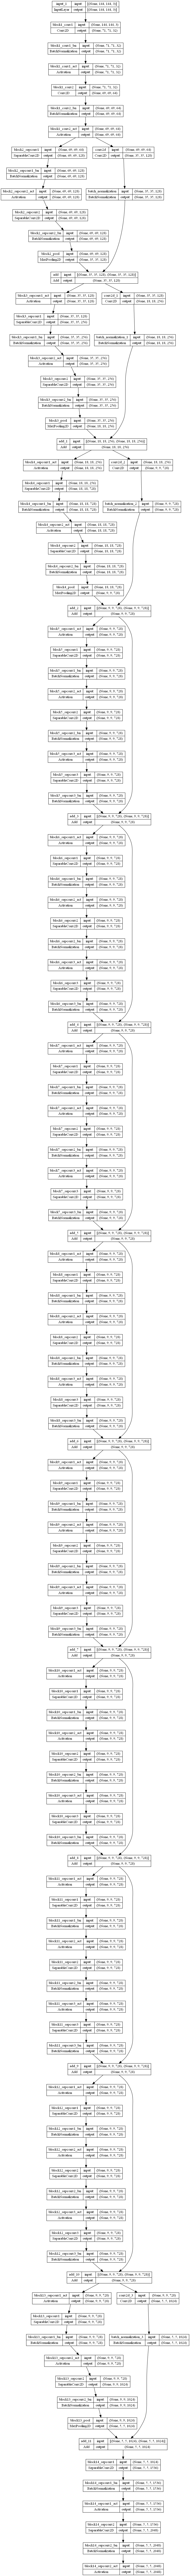

In [ ]:
tf.keras.utils.plot_model(model = xception, show_shapes=True)


In [ ]:
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=0.000005, min_delta=1e-4, mode='min')

In [ ]:
training = model.fit(X_train, y_train, batch_size = 16, validation_data=(X_valid,y_valid), class_weight=CLASS_WEIGHTS, epochs=60, callbacks=[reduce_lr_loss] )

Epoch 1/60
467/467 [==============================] - 21s 27ms/step - loss: 0.1830 - binary_accuracy: 0.5937 - val_loss: 0.1334 - val_binary_accuracy: 0.7663 - lr: 1.0000e-04
Epoch 2/60
467/467 [==============================] - 11s 24ms/step - loss: 0.1664 - binary_accuracy: 0.6571 - val_loss: 0.1391 - val_binary_accuracy: 0.7237 - lr: 1.0000e-04
Epoch 3/60
467/467 [==============================] - 11s 24ms/step - loss: 0.1601 - binary_accuracy: 0.6753 - val_loss: 0.1352 - val_binary_accuracy: 0.7379 - lr: 1.0000e-04
Epoch 4/60
467/467 [==============================] - 11s 24ms/step - loss: 0.1577 - binary_accuracy: 0.6855 - val_loss: 0.1298 - val_binary_accuracy: 0.7578 - lr: 1.0000e-04
Epoch 5/60
467/467 [==============================] - 11s 24ms/step - loss: 0.1529 - binary_accuracy: 0.6975 - val_loss: 0.1298 - val_binary_accuracy: 0.7559 - lr: 1.0000e-04
Epoch 6/60
467/467 [==============================] - 11s 24ms/step - loss: 0.1500 - binary_accuracy: 0.7029 - val_loss: 0.12

In [ ]:
opt1 = tf.keras.optimizers.SGD(lr=0.00001, momentum=0.9, decay=1e-7/60)

In [ ]:
xception.trainable = True


model.compile(loss=tf.keras.losses.binary_focal_crossentropy,
                 optimizer=opt1,
                 metrics=tf.keras.metrics.BinaryAccuracy())

training = model.fit(X_train, y_train, batch_size = 16, validation_data=(X_valid,y_valid), class_weight=CLASS_WEIGHTS, epochs=60, callbacks=[reduce_lr_loss] )

Epoch 1/60
467/467 [==============================] - 48s 93ms/step - loss: 0.1197 - binary_accuracy: 0.7980 - val_loss: 0.1127 - val_binary_accuracy: 0.8042 - lr: 1.0000e-05
Epoch 2/60
467/467 [==============================] - 43s 91ms/step - loss: 0.1164 - binary_accuracy: 0.7971 - val_loss: 0.1094 - val_binary_accuracy: 0.8070 - lr: 1.0000e-05
Epoch 3/60
467/467 [==============================] - 43s 91ms/step - loss: 0.1166 - binary_accuracy: 0.7959 - val_loss: 0.1079 - val_binary_accuracy: 0.8108 - lr: 1.0000e-05
Epoch 4/60
467/467 [==============================] - 43s 92ms/step - loss: 0.1150 - binary_accuracy: 0.7997 - val_loss: 0.1093 - val_binary_accuracy: 0.8089 - lr: 1.0000e-05
Epoch 5/60
467/467 [==============================] - 43s 92ms/step - loss: 0.1155 - binary_accuracy: 0.8031 - val_loss: 0.1069 - val_binary_accuracy: 0.8089 - lr: 1.0000e-05
Epoch 6/60
467/467 [==============================] - 43s 92ms/step - loss: 0.1149 - binary_accuracy: 0.8006 - val_loss: 0.10

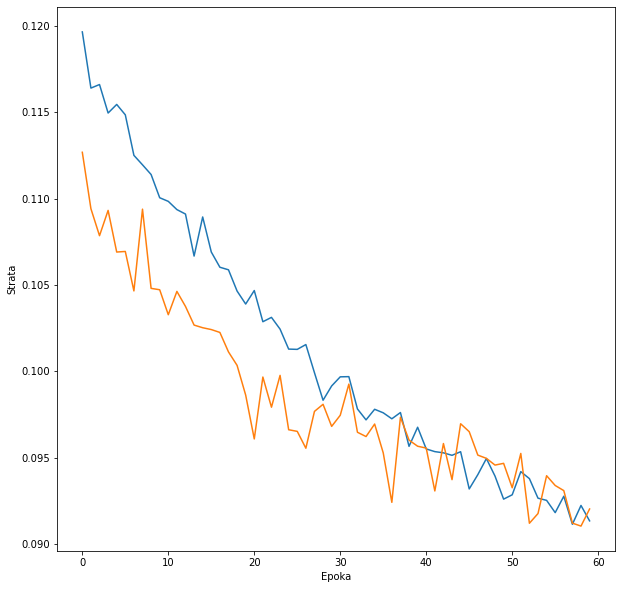

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.show()

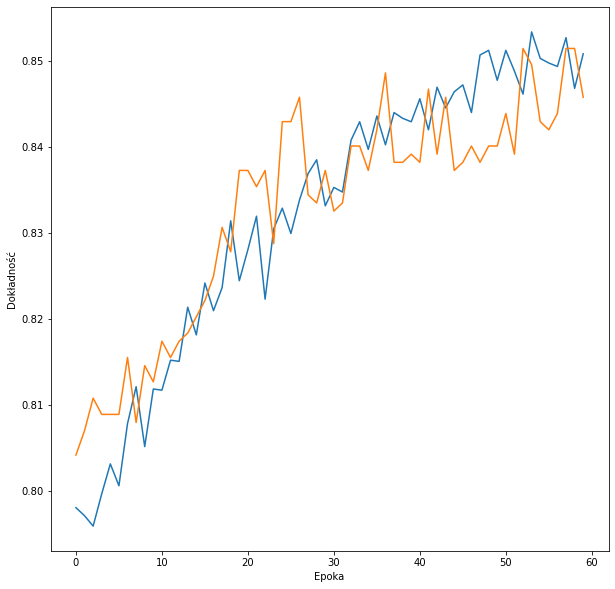

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(training.history['binary_accuracy'])
plt.plot(training.history['val_binary_accuracy'])
plt.ylabel('Dokładność')
plt.xlabel('Epoka')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import seaborn as sns


In [ ]:
y_train_prob_pred = model.predict(X_train) # predykcja klas - zbiór walidacyjny
y_train_pred = [(0 if prob[0]<=0.5 else 1) for prob in y_train_prob_pred]

234/234 [==============================] - 9s 33ms/step


In [ ]:
print('Dokładność zbioru treningowego:', accuracy_score(y_train, y_train_pred))

Dokładność zbioru treningowego: 0.8809970517287591


In [ ]:
test = prepare_images(test_set)
X_test, y_test = prepare_dataset(test)

In [ ]:
del test
del test_set

In [ ]:
y_test_prob_pred = model.predict(X_test) # predykcja klas - zbiór testowy
y_test_pred = [(0 if prob[0]<=0.5 else 1) for prob in y_test_prob_pred]

67/67 [==============================] - 3s 38ms/step


In [ ]:
print('Dokładność zbioru testowego:', accuracy_score(y_test, y_test_pred))

Dokładność zbioru testowego: 0.8571428571428571


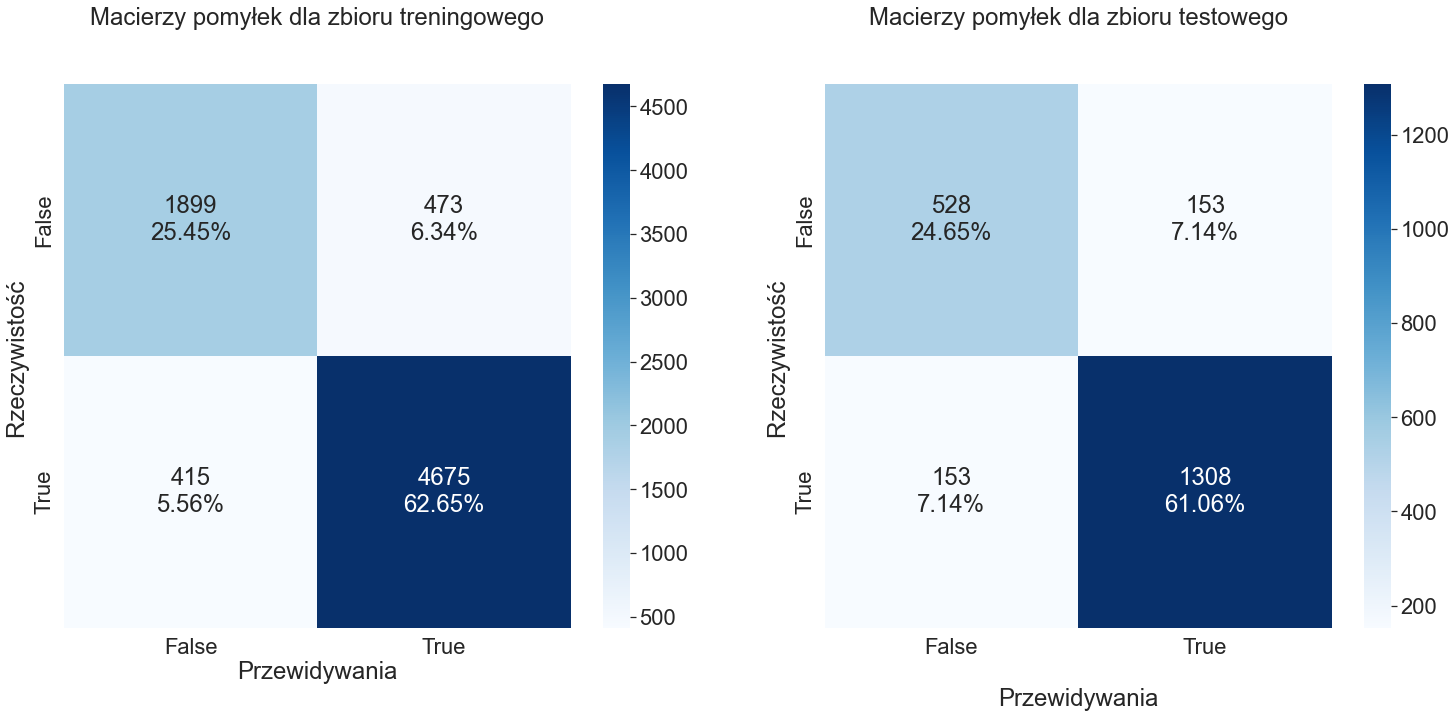

In [ ]:
plt.rcParams["figure.figsize"] = (25,10)
sns.set(font_scale=2.0)
plt.subplot(1,2,1)
cm = confusion_matrix(y_train, y_train_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Macierzy pomyłek dla zbioru treningowego\n\n');
ax.set_xlabel('Przewidywania')
ax.set_ylabel('Rzeczywistość ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.subplot(1,2,2)
cm = confusion_matrix(y_test, y_test_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Macierzy pomyłek dla zbioru testowego\n\n');
ax.set_xlabel('\nPrzewidywania')
ax.set_ylabel('Rzeczywistość ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.savefig('confusion_matrix')


In [ ]:
print("Raport klasyfikacji dla zbioru treningowego:\n")
print(classification_report(y_train, y_train_pred))
print('\n')
print("Raport klasyfikacji dla zbioru testowego:\n")
print(classification_report(y_test, y_test_pred))

Raport klasyfikacji dla zbioru treningowego:

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81      2372
         1.0       0.91      0.92      0.91      5090

    accuracy                           0.88      7462
   macro avg       0.86      0.86      0.86      7462
weighted avg       0.88      0.88      0.88      7462



Raport klasyfikacji dla zbioru testowego:

              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78       681
         1.0       0.90      0.90      0.90      1461

    accuracy                           0.86      2142
   macro avg       0.84      0.84      0.84      2142
weighted avg       0.86      0.86      0.86      2142



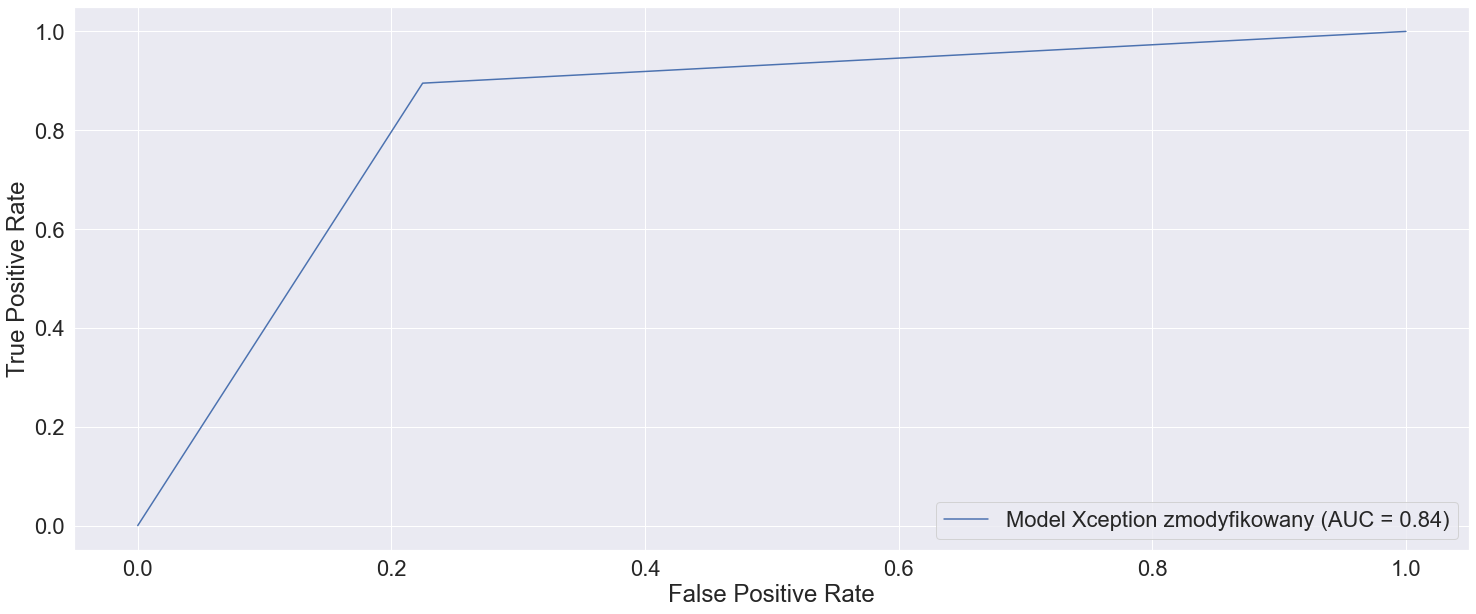

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Model Xception zmodyfikowany')


display.plot()
plt.show()
